# This notebook demonstrates several methods for assessing the frequency
# of extreme precipitation events.

# For reference, a paper using extreme value techniques to study rainfall in Brazil:
# https://link.springer.com/article/10.1007/s42452-020-03199-8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import genpareto, genextreme
from scipy.optimize import minimize
from scipy.special import gamma
import os

In [2]:
def tail_shape(z, p0=0.1, family="powerlaw"):
    """
    Returns values x, p such that the slope of p on x estimates the
    shape parameter (tail index) of a distribution with power-law
    tails (if family='powerlaw'), or the rate parameter of a
    distribution with exponential tails (if family='exponential').
    The upper p0 fraction of the data in z are used to produce x, p.
    The returned values in x are the order statistics of z in the
    Exponential case, and the log order statistics of z in the Pareto
    case. The returned values in p are derived from probability
    points.  Scatterplot p against x to get a visualization of the
    tail shape.
    """

    if family not in ["exponential", "powerlaw"]:
        raise ValueError("Unknown family %s" % family)

    p = 1 - p0
    z = np.asarray(z)
    z.sort()
    n = len(z)
    m = int(np.around(p*n))
    x = z[m-1:]
    if family == "powerlaw":
        x = np.log(x)
    p = np.log(1 - np.arange(m, n+1) / (n+1))
    return x, p

In [3]:
def fit_tail_reg(x, ax, p0=0.99, family="powerlaw"):
    """
    Use least squares regression in the upper 'p0' fraction of the right
    tail of a quantile plot to estimate the shape parameter, and add the
    best fit line to the plot in axes 'ax'.
    """

    x, p = tail_shape(x, p0=p0, family=family)

    ax.plot(x, p, color="orange")

    # Estimate the tail index using a least squares fit to the order
    # statistics.
    alpha_hat = -np.cov(p, x)[0, 1] / np.var(x)
    icept = p.mean() + alpha_hat*x.mean()

    # The coordinates of the best-fit line
    xx = np.asarray([x.min(), x.max()])
    yy = icept - alpha_hat*xx

    ax.plot(xx, yy, color="purple")

    return icept, alpha_hat

In [4]:
def hill(z, k=200):
    """
    Estimate the tail index of a distribution with poower law tails using Hill's
    estimator, based on the upper k order statistics.
    """

    z = np.sort(z)
    z = np.log(z[-k:])
    return 1 / (z[1:] - z[0]).mean()

In [5]:
def plot_hill(z):
    """
    Plot the Hill estimate of the tail index for a range
    of values of the tuning parameter k.
    """

    kv = np.arange(20, 501, 5)
    ta = np.asarray([hill(z, k=k) for k in kv])

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("Hill estimate of the tail index")
    ax.plot(kv, ta)
    ax.set_xlabel("k", size=16)
    ax.set_ylabel("Tail index estimate", size=16)
    pdf.savefig()

In [6]:
def fit_gev(x):
    """
    Fit a generalized extreme value distribution (GEV) using maximum likelihood
    estimation to the data in 'x'. Probability weighted moments are used to obtain
    starting values:
    https://www.stat.cmu.edu/technometrics/80-89/VOL-27-03/v2703251.pdf
    """

    x = np.sort(x)
    n = len(x)

    # Plotting positions
    pp = np.arange(1/2, n + 1/2) / n

    # Calculate the first three probability weighted moments
    b = np.zeros(3)
    for r in range(3):
        b[r] = np.dot(pp**r, x) / n

    # The PWM estimator of Hoskins et al.
    c = (2*b[1] - b[0]) / (3*b[2] - b[0])  - np.log(2) / np.log(3)
    shape = 7.8590*c + 2.9554*c**2
    scale = (2*b[1] - b[0]) * shape / (gamma(1 + shape) * (1 - 1/2**shape))
    loc = b[0] + scale*(gamma(1 + shape) - 1) / shape

    # Get the MLE
    x0 = np.asarray([shape, loc, scale])
    def f(par):
        shape, loc, scale = par
        d = genextreme(shape, loc=loc, scale=scale)
        return -d.logpdf(x).sum()

    rr = minimize(f, x0, method="powell")
    shape, loc, scale = rr.x
    return genextreme(shape, loc=loc, scale=scale)

In [7]:
def block_max(dx):
    """
    Calculate the maximum precipitation value for each complete year,
    and fit a generalized extreme value (GEV) distribution to the
    data.  Then use the fitted model to calculate returns for a sequence
    of time horizons, and create a QQ plot to assess goodness-of-fit.
    """

    # Get the annual maximum for all complete years
    dx = dx.query("year > 1958 & year < 2023")
    yrmx = dx.groupby("year")["PRCP"].agg(np.max)

    # Fit a generalized extreme value distribution to the block maxima.
    gev = fit_gev(yrmx)

    # m-observation returns
    rr = pd.DataFrame({"Years": [10, 100, 500, 1000]})
    rr["Return"] = gev.ppf(1 - 1/rr.Years)
    print("Returns based on GEV:")
    print(rr)

    # Make a QQ plot to assess goodness of fit
    z = np.sort(yrmx)
    n = len(z)
    pp = np.arange(1, n + 1) / (n + 1)
    qq = gev.ppf(pp)

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.plot(qq, z)
    ax.set_xlabel("GEV quantiles")
    ax.set_ylabel("Order statistics")
    ax.set_title("GEV fit to annual maxima")
    pdf.savefig()

    return gev

In [8]:
def gp_estimate(z):
    """
    Estimate the parameters of a generalized Pareto distribution
    using the empirical Bayes method of Zhang and Stephens.
    https://www.jstor.org/stable/pdf/40586625.pdf
    """

    z = np.sort(z)
    n = len(z)
    xstar = z[int(np.round(n/4 + 0.5))]
    m = np.ceil(20 + np.sqrt(n))
    xmax = z.max()

    jj = np.arange(1, m+1)
    tgrid = 1/xmax + (1 - np.sqrt(m/(jj-0.5))) / (3 * xstar)

    def profile(theta):
        k = -np.log(1 - theta*z).mean()
        return n*(np.log(theta/k) + k - 1)

    ltg = np.asarray([profile(t) for t in tgrid])
    ltg -= ltg.max()
    Ltg = np.exp(ltg)
    Ltg /= Ltg.sum()
    theta_hat = np.dot(Ltg, tgrid)
    k_hat = -np.log(1 - theta_hat*z).mean()
    scale_hat = k_hat / theta_hat

    return genpareto(-k_hat, scale=scale_hat)

In [9]:
def eb_analysis(z):
    """
    Fit a generalized Pareto model to the exceedances derived from z,
    using empirical Bayes estimation, and create a QQ plot to assess
    the goodness-of-fit.
    """

    # Exceedances
    z = z[z > thresh] - thresh

    # Empirical Bayes estimate of Zhang and Stephens.
    eb = gp_estimate(z)

    n = len(z)
    pp = np.linspace(1/2, n - 1/2, n) / n # plotting positions
    qq = eb.ppf(pp)
    z = np.sort(z)

    # QQ plot to show goodness of fit
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("EB: shape=%.3f scale=%.3f" % (eb.args[0], eb.kwds["scale"]))
    ax.plot(qq, z)
    plt.xlabel("GP quantiles (EB)", size=16)
    plt.ylabel("Order statistics", size=16)
    pdf.savefig()

    return eb

In [10]:
def plot_tails(z, p0, thresh, family):

    n = len(z)

    # Exceedances
    z = z[z >= thresh]
    z -= thresh

    # The number of selected observations
    m = int(np.around(p0*n))

    xlabel = "log Q(p)" if family == "powerlaw" else "Q(p)"

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    icept, alpha = fit_tail_reg(z, ax, p0=p0, family=family)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel("log(1-p)", size=16)
    ti = "%s model, threshold=%.1f, top %.1f%% (n=%d), alpha=%.3f" %\
           (family.title(), thresh, 100*p0, m, alpha)
    plt.title(ti)
    pdf.savefig()

In [11]:
def check_gp_estimate(shape, scale, thresh, n=100000):
    z = genpareto.rvs(shape, scale=scale, size=n)
    z = z[z > thresh] - thresh
    #shape_hill = hill(z)
    eb = gp_estimate(z)
    return eb#, shape_hill

In [12]:
def mobs_return(z, mr, thresh, family="exponential", gp=None):
    """
    Calculate the m-observation returns for the data in z, using either
    an exponential or generalized Pareto model.
    """

    z = np.asarray(z)
    n = len(z)

    # Select only extreme values and translate back to the origin
    ix = np.flatnonzero(z >= thresh)
    q = len(ix) / n # proportion of values exceeding the threshold
    z = z[ix]
    z -= thresh

    pr = 1 - 1 / (q * mr)

    if family == "exponential":
        mn = z.mean()
        print("Mean = %.2f" % mn)
        m0 = thresh - mn*np.log(1 - pr)
    elif family == "generalizedpareto":
        print("Shape=%.2f" % eb.args[0])
        print("Scale=%.2f" % eb.kwds["scale"])
        m0 = thresh + gp.ppf(pr)
    else:
        raise ValueError("!!")

    return m0

In [13]:
pdf = PdfPages("extremes_python.pdf")

In [14]:
# Change this to point to the location of the data, matching the path
# name in get_data.py
target_dir = "/home/kshedden/data/Teaching/precip"

In [15]:
# Choose a specific location to analyze.
fname = "USW00094847.csv" # Detroit
#fname = "USW00012839.csv" # Miami

In [16]:
df = pd.read_csv(os.path.join(target_dir, fname + ".gz"), parse_dates=["DATE"],
                 low_memory=False)

In [17]:
# We only care about these two variables.
df = df[["DATE", "PRCP"]].dropna()

In [18]:
# Add a year variable for block-maxima (GEV) analyses
df["year"] = df["DATE"].dt.year

In [19]:
# Convert precipitation to millimeters
df["PRCP"] /= 10

In [20]:
# Use this threshold for calculating exceedances
thresh = 5.0

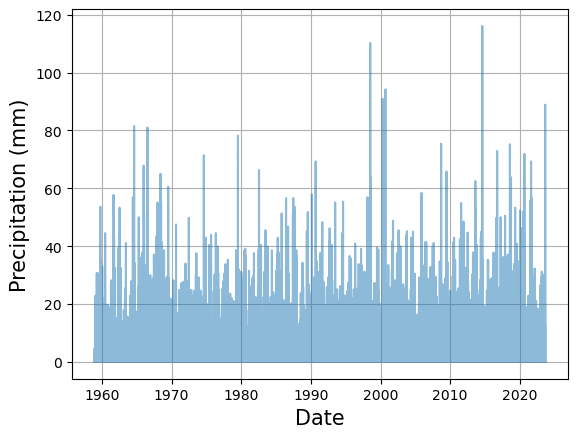

In [21]:
# Plot the data as a time series
plt.clf()
plt.grid(True)
plt.plot(df["DATE"], df["PRCP"], "-", alpha=0.5)
plt.xlabel("Date", size=15)
plt.ylabel("Precipitation (mm)", size=15)
pdf.savefig()

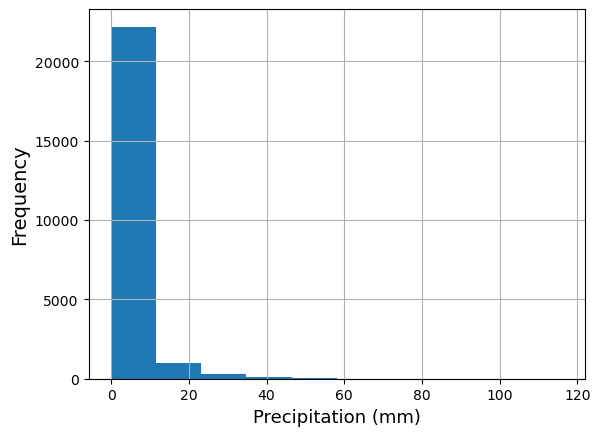

In [22]:
# Plot the data as a histogram
plt.clf()
plt.grid(True)
plt.hist(df["PRCP"])
plt.xlabel("Precipitation (mm)", size=13)
plt.ylabel("Frequency", size=14)
pdf.savefig()

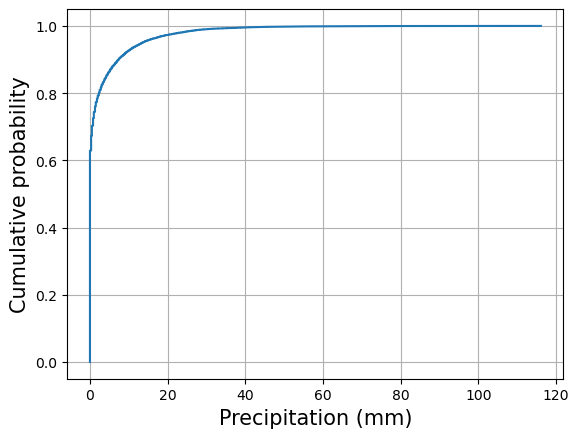

In [23]:
# Plot the data as a CDF
plt.clf()
plt.grid(True)
x = np.sort(df["PRCP"])
p = np.linspace(0, 1, len(x))
plt.plot(x, p, "-")
plt.xlabel("Precipitation (mm)", size=15)
plt.ylabel("Cumulative probability", size=15)
pdf.savefig()

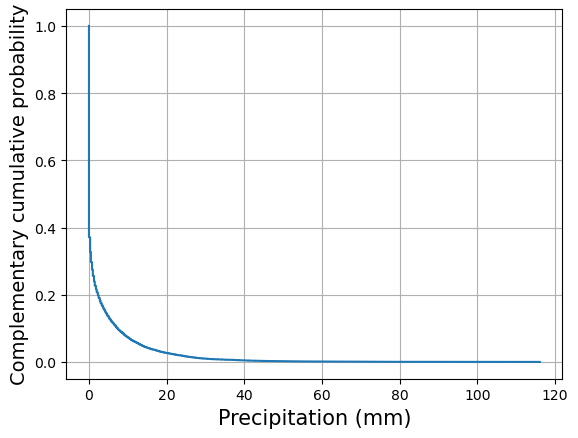

In [24]:
# Plot the data as a complementary CDF (ccdf, survival function)
plt.clf()
plt.grid(True)
x = np.sort(df["PRCP"])
p = np.linspace(0, 1, len(x))
plt.plot(x, 1 - p, "-")
plt.xlabel("Precipitation (mm)", size=15)
plt.ylabel("Complementary cumulative probability", size=14)
pdf.savefig()

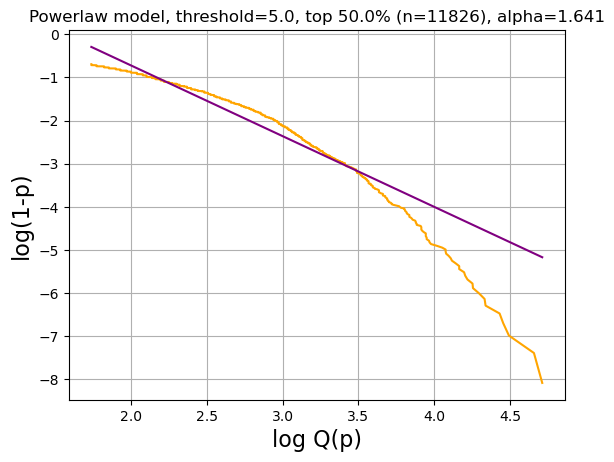

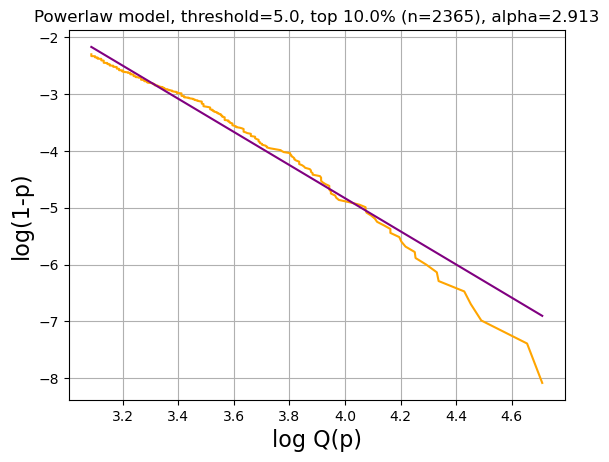

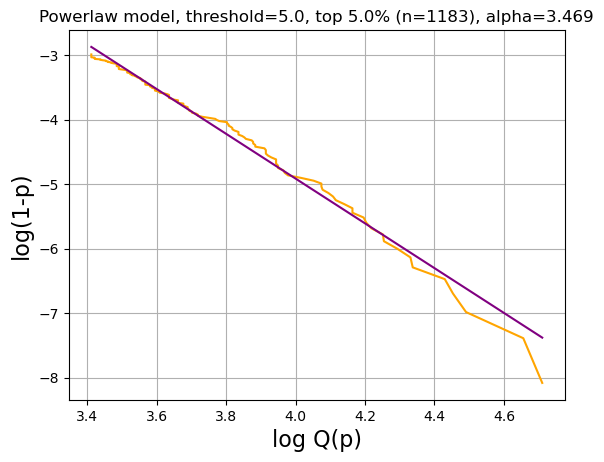

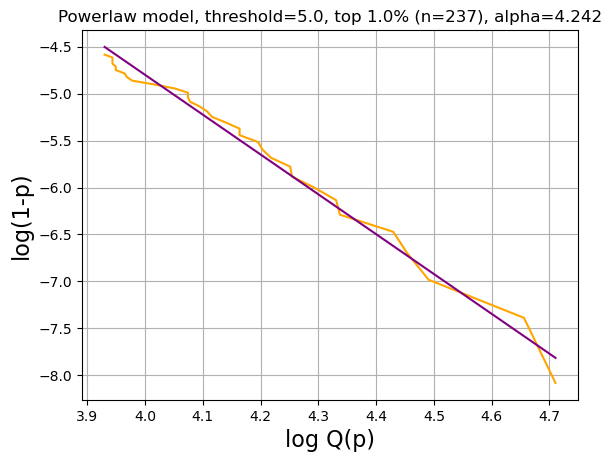

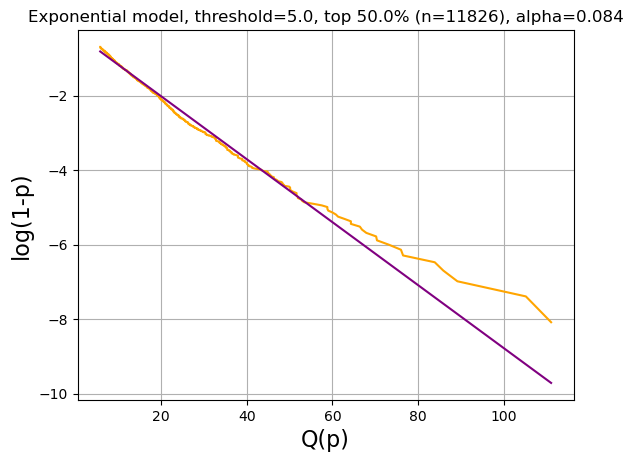

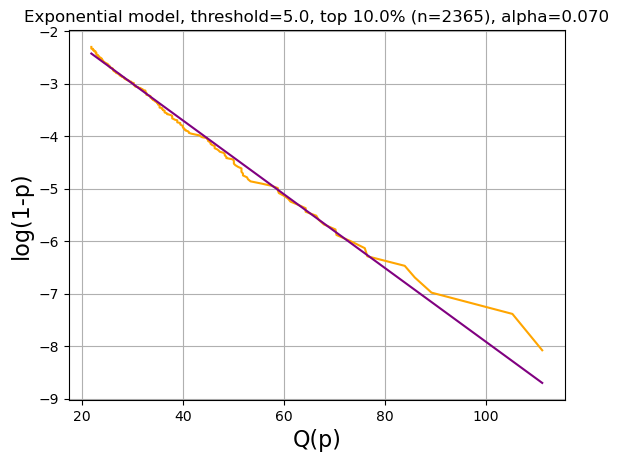

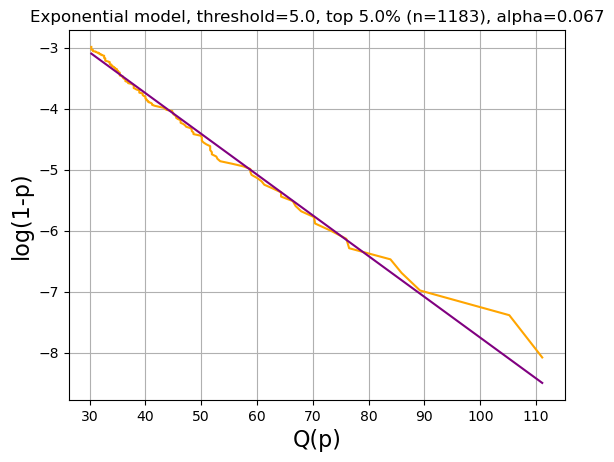

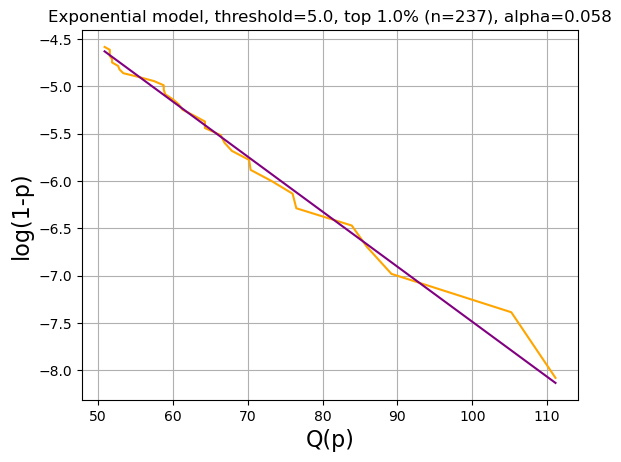

In [25]:
# Quantile plots
for family in ["powerlaw", "exponential"]:
    for p0 in [0.5, 0.1, 0.05, 0.01]:
        plot_tails(df["PRCP"], p0, thresh, family)
        plt.show()

(23651, 3)

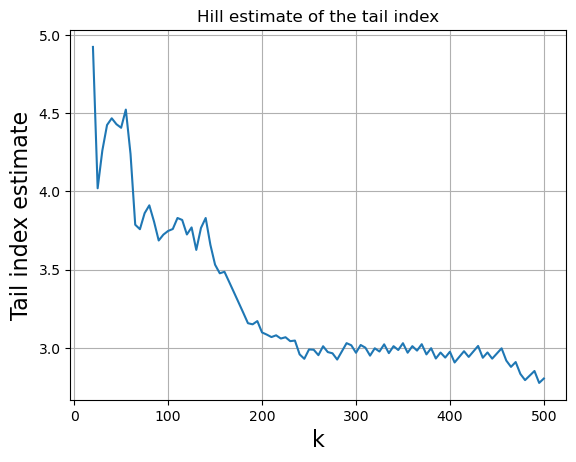

In [26]:
plot_hill(df["PRCP"])
df.shape

Returns based on GEV:
   Years      Return
0     10   77.263590
1    100  128.078732
2    500  178.708592
3   1000  205.725153


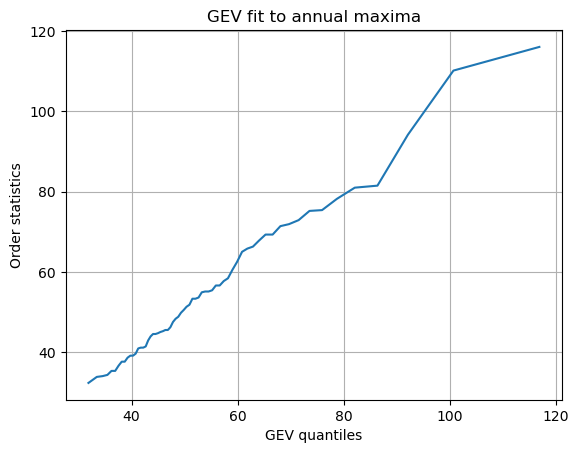

In [27]:
# Fit generalized extreme value distributions to the block (annual) maxima.
gev = block_max(df)

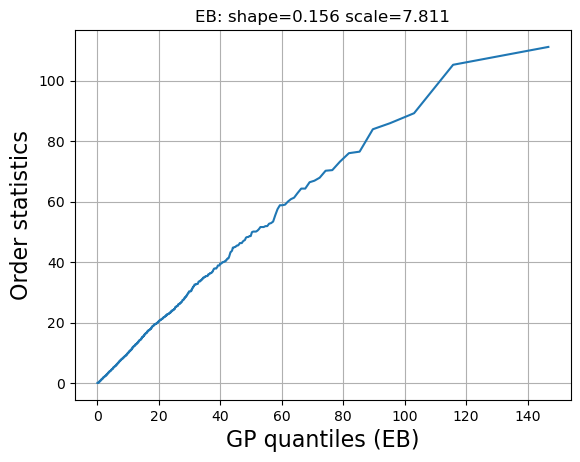

In [28]:
# Fit generalized Pareto models to the exceedances
eb = eb_analysis(df["PRCP"])

In [29]:
# Calculate m-observation returns based on various models fit
# to the 24 hour rainfall totals.
yr = np.r_[1, 10, 100, 500, 1000]
cfg = [("exponential", None), ("generalizedpareto", eb)]
for (f,g) in cfg:
    print("\nReturns based on %s:" % f)
    mr = mobs_return(df["PRCP"], 365 * yr, thresh, family=f, gp=g)
    rr = pd.DataFrame({"Years": yr, "MR": mr})
    print(rr)


Returns based on exponential:
Mean = 9.23
   Years          MR
0      1   41.100196
1     10   62.363368
2    100   83.626541
3    500   98.488861
4   1000  104.889713

Returns based on generalizedpareto:
Shape=0.16
Scale=7.81
   Years          MR
0      1   47.067666
1     10   86.890233
2    100  143.924897
3    500  197.867623
4   1000  225.611062


In [30]:
pdf.close()